# TensorFlow-Keras Functional API
*by Marvin Bertin*
<img src="../../images/keras-tensorflow-logo.jpg" width="400">

## TF-Keras Models

In TF-Keras they're are two types of models available:
- sequential models
    - simple linear stacking of layers
- functional models
    - defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers

Since TF-Keras's functional API is more flexible and allows you to contruct more advanced models, we will focus our efforts on these types of models.

<img src="../../images/keras_model.png" width="400">

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

tf_keras = tf.contrib.keras

# Load MNIST Dataset

MNIST is a simple computer vision dataset. It consists of images of handwritten digits in black and white. It also includes labels for each image, telling us which digit it is. The numbers goes from 0 to 9. Therefore, this is a ten class classification problem.

In this lesson, we're going to construct a simple Convolutional Neural Network with TF-Keras. Then we will train the model to look at images and predict what digits they are.

This will not be a state-of-the-art model. Instead it will introduce us to model building in Tensorflow with the high level layers we've learned so far. Despite its simplicity, we will see that we can already perform quite well on this dataset.

In [2]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf_keras.datasets.mnist.load_data(
    "/your/local/path/mnist.npz")

# Plot Dataset Sample

Let's visualize a random sample of 100 images plotted on a 10 by 10 grid.

In [3]:
def plot_10_by_10_images(images):

    # figure size
    fig = plt.figure(figsize=(8, 8))
    
    # crop image
    images = [image[3:25, 3:25] for image in images]
    
    # plot image grid
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            ax.matshow(images[10*y+x], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

The dataset is made of hand-written digits of different shapes and stroke thickness.
The goal of the task, is to build and train a model that takes in the images' raw pixel and predict the correct class.

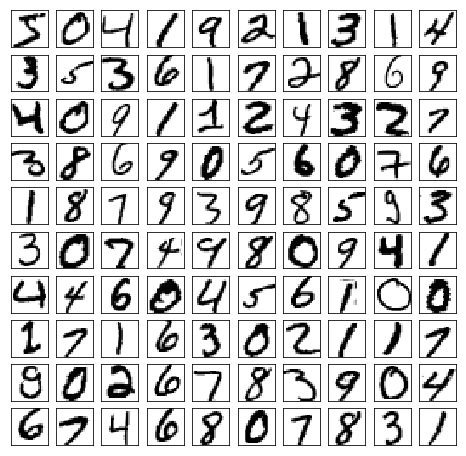

In [4]:
plot_10_by_10_images(x_train[:100])

# Preprocess Images

Before we can build and train a model, the dataset first needs to be reshaped and preprocessed.

We're going to apply now the simplest image preprocessing there is. In the next lesson we will explore more advanced preprocessing techniques and data augmentation methods. For the time being, simple preprocessing will be enough for this image classification task.

## Preprocessing Steps

- reshaped train and test input data into 4D tensors (batch, width, height, channel)
- reshape train and test target data into one-hot vector encoding
- normalize pixel values from 0-255 to 0-1 for better training

<img src="../../images/onehotencoding.png" width="800">

In [9]:
def preprocess_images((x_train, y_train), (x_test, y_test), num_classes):
    # expand to 4d tensor
    X_train = np.expand_dims(x_train, 3) 
    X_test = np.expand_dims(x_test, 3)

    # normalize images
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    # binarize target matrix (one-hot vector encoding)
    Y_train = tf_keras.utils.to_categorical(y_train, num_classes)
    Y_test = tf_keras.utils.to_categorical(y_test, num_classes)

    print('X_train shape:', X_train.shape)
    print('Y_train shape:', Y_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    
    return (X_train, Y_train), (X_test, Y_test)

# Run Preprocess Step

In [10]:
# number of classes
num_class = 10

# preprocess images
(X_train, Y_train), (X_test, Y_test) = preprocess_images((x_train, y_train), (x_test, y_test), num_class)

('X_train shape:', (60000, 28, 28, 1))
('Y_train shape:', (60000, 10))
(60000, 'train samples')
(10000, 'test samples')


# Model Hyper-parameters

A neural network's parameters are the trainable weights of the model. These weights are trained through gradient descent optimization with back-propagation.

There exist another type of parameters, called _hyper-parameters_. These parameters are not trainable and are set by the user. The optimial hyper-parameters are usually found through experimental search, often called _hyper-parameter tuning_.

Below are initial good initial hyper-parameters to get started with our model.

In [11]:
params = {
    "num_classes": 10, # number of classes
    "input_shape": (28,28,1), # input image size
    "conv_filters": 16, # number of convolutional feature maps
    "conv_kernel": (3,3), # convolutional feature map size
    "pool_kernel": (2,2), # pooling window size
    "dense_size": 128, # size of fully connect layer
    "dropout": 0.4, # ratio of neurons to drop during trainin
    "learning_rate": 0.01 # learning rate
}

# Simple CNN Architecture


Let's build our first Convolutional Neural Network!

This will be a simple neural network to get us familiarized with the TF-Keras functional API. We will be using all the core layers found in all CNNs. This will give you the tools to then build almost any of the more complicated CNNs.

In [14]:
def simpleCNN(params):  

    # TensorFlow default graph
    tf.reset_default_graph()

    # input image tensor
    inputs = tf_keras.layers.Input(shape = params["input_shape"])

    # convolutional layer
    net = tf_keras.layers.Conv2D(params["conv_filters"], params["conv_kernel"],
                                 padding= 'same', activation=tf.nn.relu)(inputs)

    # maxpooling layer
    net = tf_keras.layers.MaxPool2D(params["pool_kernel"])(net)

    # flatten/reshape layer
    net = tf_keras.layers.Flatten()(net)

    # fully connected layer
    net = tf_keras.layers.Dense(params["dense_size"], activation=tf.nn.relu)(net)
    
    # dropout layer
    net = tf_keras.layers.Dropout(params["dropout"])(net)

    # fully connected layer
    outputs = tf_keras.layers.Dense(params["num_classes"], activation=tf.nn.softmax)(net)

    # model
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)

    # SGD/optimizer
    optimizer = tf_keras.optimizers.SGD(lr=params["learning_rate"])

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = tf_keras.losses.categorical_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.categorical_accuracy])

    print(model.summary())
    
    return model

## Model Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

- An optimizer
    - This could be an existing optimizer provided by tensorflow (such as rmsprop or adagrad), or a custom Optimizer class
- A loss function
    - This is the objective that the model will try to minimize. It can be an existing tensorflow loss function (such as categorical_crossentropy or mse), or it can be a custom objective function.
- A list of metrics
    - For any classification problem you can set the evaluation metric that the model will test its performance on. A metric could be an existing tensorflow metric or a custom metric function.

# Generate Computational Graph

You can explore the defined computational graph to get a better overview of the neural network model. Although we've built a relatively simple model, we have over 400,000 trainable parameters. Note that most of the weights come from the fully connected layer. Convolutional layers aren't just great for images, they are also much more computationally efficient than most other layers.

In [15]:
model = simpleCNN(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

# Train Neural Network

To train our CNN, we simply need to call the fit function.
Let's pass in both our train and test data and set the batch size to 64.

In [16]:
model.fit(x=X_train, y=Y_train, batch_size=64,
          verbose=1, epochs=6, validation_data=(X_test,Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 23s - loss: 0.7304 - categorical_accuracy: 0.7864 - val_loss: 0.2851 - val_categorical_accuracy: 0.9184
Epoch 2/6
60000/60000 [==============================] - 23s - loss: 0.3374 - categorical_accuracy: 0.9007 - val_loss: 0.2198 - val_categorical_accuracy: 0.9375
Epoch 3/6
60000/60000 [==============================] - 23s - loss: 0.2754 - categorical_accuracy: 0.9184 - val_loss: 0.1806 - val_categorical_accuracy: 0.9467
Epoch 4/6
60000/60000 [==============================] - 23s - loss: 0.2427 - categorical_accuracy: 0.9290 - val_loss: 0.1606 - val_categorical_accuracy: 0.9522
Epoch 5/6
60000/60000 [==============================] - 23s - loss: 0.2212 - categorical_accuracy: 0.9342 - val_loss: 0.1466 - val_categorical_accuracy: 0.9581
Epoch 6/6
60000/60000 [==============================] - 23s - loss: 0.2048 - categorical_accuracy: 0.9396 - val_loss: 0.1337 - val_categorical_a

# Evaluate Model Performance

Evaluation based on the evaluation metrics passed at compile time can be run on your test data with the evaluate method.

In [17]:
score = model.evaluate(X_test, Y_test, verbose=1)
print
print('Test score:', score[0])
print('Test accuracy:', score[1])

 9984/10000 [============================>.] - ETA: 0s
('Test score:', 0.13374883404076099)
('Test accuracy:', 0.95979999999999999)


# Make Predictions with Trained Model

Once your model is trained, you can make predictions on any arbitrary observations by calling the predict methods.

Let's make a prediction for the first 10 images in the test dataset.
The predict method returns the output of the softmax, which represents the multinomial class probabilities per observation. The prediction is simple the class with the highest probability.

In [23]:
# make predictions from trained model
class_probabilities = model.predict(X_test[:10])

predictions = np.argmax(class_probabilities, axis=1)
print("Prediction: {}".format(predictions))

Prediction: [7 2 1 0 4 1 4 9 6 9]


# Plot Predictions

Let's compare our model predictions with the original handwritten digit images by plotting the first 10 images in the test set.

In [20]:
def plot_images_together(images, predictions):
    pred_str = "   ".join(map(str,predictions))
    
    fig = plt.figure(figsize=(30, 6))
    images = [image[:, 3:25] for image in images]
    image = np.concatenate(images, axis=1)
    
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    
    plt.text(0.5, -0.5,pred_str, fontsize=100, horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes,
             bbox=dict(facecolor='green', alpha=0.4))
    plt.show()

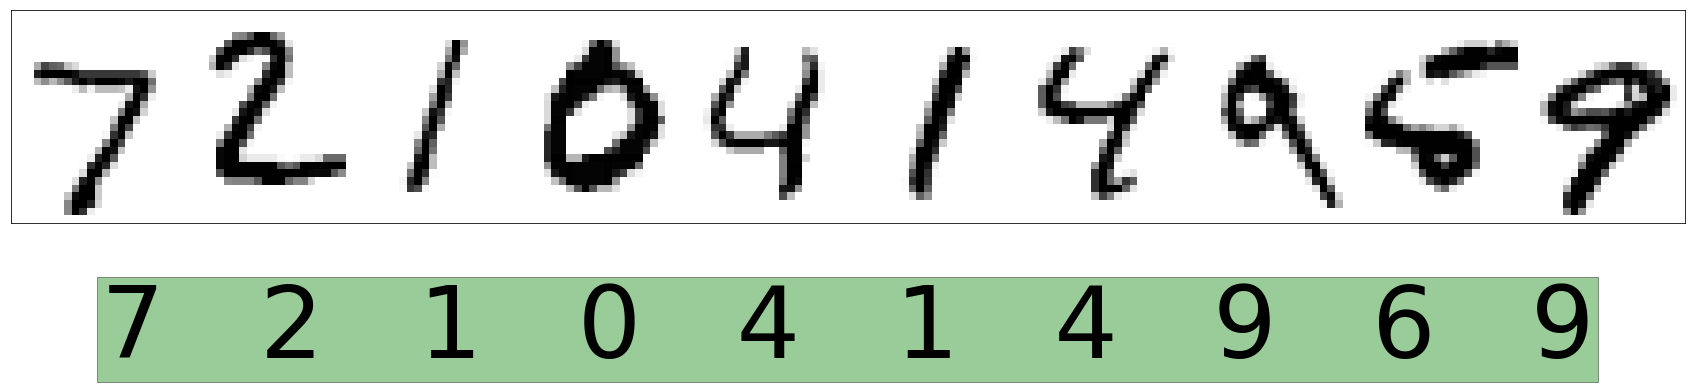

In [21]:
plot_images_together(x_test[:10], predictions)

## Next Lesson
### Image pre-processing in TF-Keras
-  You will learn about image pre-processing and augmentation

<img src="../../images/divider.png" width="100">